# Pokemon Recommender


This is a Content based Recommender system which recommends pokemon similar to the Input pokemon.

When i found this dataset, I thought it would be great to build a pokemon recommender system since I like Pokemon

This dataset contains pokemons from first six generations and their stats, 
I'll be using stats and type of pokemon to know similarities between pokemon, 
I have labelled each pokemon with Normal/Mega/Legendary tag and included them while calculating similarity, it is kind of like adding more weight to the similarity score of pokemons with similar tag

Below I am importing required libraries

* numpy, pandas basic libraries
* seaborn and matplotlib for plotting
* cosine_similarity, The heart of this model, to find the similarities between pokemons
* warnings to ignore warnings
* standard scaler to bring down the stats of the pokemon to same scale


In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
poke_df = pd.read_csv('Pokemon.csv')
poke_df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


So total 800 Pokemons

In [3]:
poke_df.shape

(800, 13)

There are two types of pokemon
* Single type pokemon
* Dual type pokemon

Below null values in Type 2 are actually of pokemon with only one type

In [4]:
poke_df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Filling the null values with 'None' string

Adding a new column to the dataframe with tags Normal/Mega/Legendary

* Normal tag is for normal pokemon
* Mega tag for Mega evloved pokemon and
* Legendary for Legendary pokemon

Since there is already a column which says whether a pokemon is legendary or not, I'll be using that to tag Legendary pokemon, For Mega I'll be using str.rfind('Mega ') to mark the Mega evolved pokemons and rest as normal

There are two pokemons Meganium and Yanmega, which have mega in their , since Yanmega has small case m so it's not a problem but Meganium starts with upper case M, so to avoid this I added space to "Mega' '" since all mega pokemons have space after the word 'Mega' to tag only Mega pokemons.

Dropped columns which are not required

In [5]:
poke_df['Type 2'].fillna(value='None',inplace=True)
poke_df['Pokemon Type'] = poke_df[['Name','Legendary']].apply(lambda x : 'Legendary' if x[1]==True else('Mega' if x[0].rfind('Mega ')!=-1 else 'Normal'),axis=1)

poke_df.drop(columns=['#','Legendary'],inplace=True)
poke_df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,Normal
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,Normal
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,Normal
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,Mega
4,Charmander,Fire,None,309,39,52,43,60,50,65,1,Normal


Below is the plot to check the count of the features

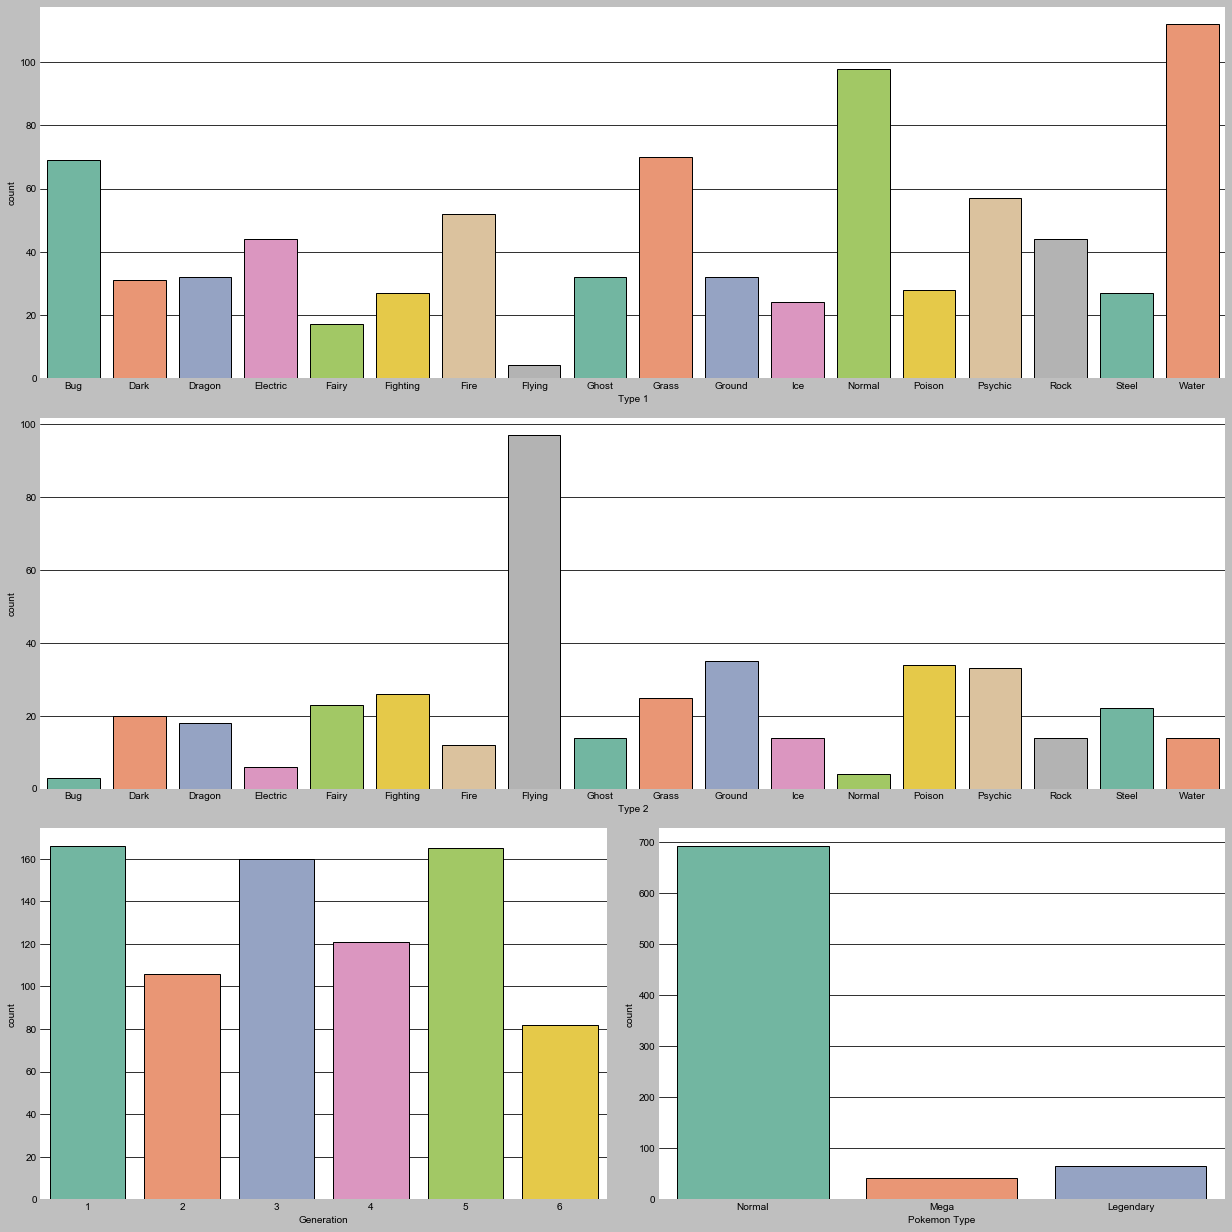

In [6]:
import matplotlib.gridspec as gridspec

plt.style.use('seaborn-darkgrid')
plt.style.use('grayscale')
Palette = 'Set2'

fig = plt.figure(figsize=(17,17),constrained_layout=True)
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
sns.countplot(x = 'Type 1', 
              data = poke_df, 
              order=sorted(poke_df['Type 1'].unique().tolist()), 
              palette=Palette, ax=ax1, linewidth=1, edgecolor='black')

ax2 = fig.add_subplot(gs[1, :])
sns.countplot(x = 'Type 2', 
              data = poke_df[poke_df['Type 2']!='None'], 
              order=sorted(poke_df['Type 1'].unique().tolist()), 
              palette=Palette, ax=ax2, linewidth=1, edgecolor='black')

ax3 = fig.add_subplot(gs[2, :1])
sns.countplot(x = 'Generation', data = poke_df, palette=Palette, ax=ax3, linewidth=1, edgecolor='black')


ax4 = fig.add_subplot(gs[2, 1:])
sns.countplot(x = 'Pokemon Type', data = poke_df, palette=Palette, ax=ax4, linewidth=1, edgecolor='black')



Below I made count vectorizer dataframe of Pokemon types, by passing in zero matrix of 800 rows (poke_df rows) and 19 columns (len of type 2 unique strings)

Type 1 and Type 2 have same categories but why i used type 2 is because it has an additional 'None' string which i added while filling in null values, so that the type 2 of single type pokemon will be taken as 'None' when i run for loop, Later this None column will be dropped from countvectorizer dataframe

In the for loop below i took type 1 and type 2 of every row from original dataframe and passed it as list to .loc of every row in zero matrix and assigned it to 1, so it goes to that respective type column and marks it as 1

Initially i tried using pd.get_dummies['Type 1','Type 2'] , but the problem with this is it made 37 columns treating the same type in type1 and type2 as different types, for example if one pokemon has "Fire" in type1 and other has "Fire" in type2 ,it made two columns as Type 1_Fire and Type 2_Fire which affects the similarity score

In [7]:
type_df = pd.DataFrame(np.zeros((poke_df.shape[0],len(poke_df['Type 2'].unique())),dtype=int),
                      index = poke_df.index,columns = sorted(poke_df['Type 2'].unique().tolist()))

for i in range(len(type_df)):
    types = []
    types.append(poke_df.loc[i,'Type 1'])
    types.append(poke_df.loc[i,'Type 2'])
    type_df.loc[i,types] = 1

type_df.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,None,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
print(sorted(poke_df['Type 1'].unique().tolist()))
print(sorted(poke_df['Type 2'].unique().tolist()))

['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


I am using standard scaler on pokemon stats here

In [9]:
scaled_df = scaler.fit_transform(poke_df.drop(columns=['Name', 'Type 1', 'Type 2', 'Total', 'Generation', 'Pokemon Type']))
scaled_df = pd.DataFrame(scaled_df,columns=['HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed'])
scaled_df.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853


Made a new df using previous two dataframes and also Pokemon Type(Normal/Mega/Legendary) df, This new dataframe will be passed into cosine similarity to find similarities between pokemon

In [10]:
new_poke_df = pd.concat([type_df.drop(columns=['None']),pd.get_dummies(poke_df['Pokemon Type']),scaled_df],axis=1)
new_poke_df.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,...,Water,Legendary,Mega,Normal,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853


Cosine similarity calculates similarity between each and every pokemon which gives us a similarity matrix of shape (800,800),

So each row has 800 columns, these 800 scores in every row is the similarity score of that row's pokemon with every other pokemon

In [11]:
cos_sim = cosine_similarity(new_poke_df.values,new_poke_df.values)

In [12]:
cos_sim.shape

(800, 800)

Making a series which gives the index of pokemon when it's name is passed

In [13]:
poke_index = pd.Series(poke_df.index,index=poke_df['Name'])
poke_index['Venusaur']

2

Making a function which gives recommendations, by default the number of recommendations is set to 5 but this can be changed

* Below function takes pokemon name as input and passes it to index series which gives pokemon index
* Using this index we can take the similarity score of that particular pokemon from cosine similarity matrix
* while extracting cosine similarity of given pokemon i am also indexing each item in that respective pokemon's similarity array using enumerate, since the items in the array are in the same order as the pokemon in our original dataframe, so this index can later be used to extract pokemon names from dataframe by passing them as list
* sorting the score based on the similarity score in Descending order so that similar pokemons will be on top
* In similar_pokemon variable i am only storing scores based on recommendations leaving the first score (since it is the score of the pokemon given in the function) 
* Finally making a list of indices of those similarity score and passing them as list to the original poke_df and returing it

In [14]:
def recommend(pokemon,recommendations=5):
    index = poke_index[pokemon]
    similarity_score = list(enumerate(cos_sim[index]))
    sorted_score = sorted(similarity_score,key=lambda x : x[1],reverse=True)
    similar_pokemon = sorted_score[1:recommendations+1]
    poke_indices = [i[0] for i in similar_pokemon]
    return poke_df.iloc[poke_indices]

In [15]:
recommend('Charizard')

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
171,Typhlosion,Fire,None,534,78,84,78,109,85,100,2,Normal
518,Magmortar,Fire,None,540,75,95,67,125,95,83,4,Normal
731,Talonflame,Fire,Flying,499,78,81,71,74,69,126,6,Normal
64,Arcanine,Fire,None,555,90,110,80,100,80,95,1,Normal
135,Magmar,Fire,None,495,65,95,57,100,85,93,1,Normal


I also want to filter the results based on type,generation, which can be done using below function

In [16]:
def rec_pokemon_byFilter(pokemon,
                         recommendations = 10,
                         include_original = False,
                         Type = None,
                         Type2 = None,
                         Generation = None,
                         pokemon_type = None):
    
    '''
    Recommends top 10 Pokemon which are similar to the given Pokemon
    
    By default number of recommendations is set to 10
    
    pokemon          : Name of the pokemon in string format
    recommendation   : Number of similar pokemon in the output, value must be Integer
    include_original : Includes the given pokemon in the output dataframe, value must be boolean
    Type             : Filter output by primary type
    Type2            : Filter output by secondary type
    Generation       : Filter output by Generation 
    pokemon_type     : Filter output by Pokemon Type 
    
    '''
    index = poke_index[pokemon]
    similarity_score = list(enumerate(cos_sim[index]))
    sorted_score = sorted(similarity_score,key=lambda x : x[1],reverse=True)
    
    
    if include_original == False:
        similar_pokemon = sorted_score[1:]
    elif include_original == True:
        similar_pokemon = sorted_score
    
    poke_indices = [i[0] for i in similar_pokemon]
    df = poke_df.iloc[poke_indices]
    
    if Type != None:
        df = df[(df['Type 1'] == Type)|(df['Type 2'] == Type)]
    else:
        pass
    
    if Type2 != None:
        df = df[(df['Type 1'] == Type2)|(df['Type 2'] == Type2)]
    else:
        pass
    
    if Generation != None:
        df = df[df['Generation'] == Generation]
    else:
        pass
    
    if pokemon_type != None:
        df = df[df['Pokemon Type'] == pokemon_type]
    else:
        pass
    
    
    return df.head(recommendations) if include_original == False else df.head(recommendations+1)

In [17]:
rec_pokemon_byFilter('Dragonite',recommendations=5)

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
408,Salamence,Dragon,Flying,600,95,135,80,110,80,100,3,Normal
425,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,Legendary
426,RayquazaMega Rayquaza,Dragon,Flying,780,105,180,100,180,100,115,3,Legendary
409,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,Mega
494,GarchompMega Garchomp,Dragon,Ground,700,108,170,115,120,95,92,4,Mega


In [18]:
rec_pokemon_byFilter('Dragonite',recommendations=10,pokemon_type='Normal',include_original=True)

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
161,Dragonite,Dragon,Flying,600,91,134,95,100,100,80,1,Normal
408,Salamence,Dragon,Flying,600,95,135,80,110,80,100,3,Normal
493,Garchomp,Dragon,Ground,600,108,130,95,80,85,102,4,Normal
696,Hydreigon,Dark,Dragon,600,92,105,90,125,90,98,5,Normal
140,Gyarados,Water,Flying,540,95,125,79,60,100,81,1,Normal
267,Tyranitar,Rock,Dark,600,100,134,110,95,100,61,2,Normal
249,Kingdra,Water,Dragon,540,75,95,95,95,95,85,2,Normal
673,Haxorus,Dragon,None,540,76,147,90,60,70,97,5,Normal
776,Goodra,Dragon,None,600,90,100,70,110,150,80,6,Normal
682,Druddigon,Dragon,None,485,77,120,90,60,90,48,5,Normal


In [19]:
rec_pokemon_byFilter('Dragonite',recommendations=10,include_original=True,Type='Dragon')

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
161,Dragonite,Dragon,Flying,600,91,134,95,100,100,80,1,Normal
408,Salamence,Dragon,Flying,600,95,135,80,110,80,100,3,Normal
425,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,Legendary
426,RayquazaMega Rayquaza,Dragon,Flying,780,105,180,100,180,100,115,3,Legendary
409,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,Mega
494,GarchompMega Garchomp,Dragon,Ground,700,108,170,115,120,95,92,4,Mega
493,Garchomp,Dragon,Ground,600,108,130,95,80,85,102,4,Normal
707,Zekrom,Dragon,Electric,680,100,150,120,120,100,90,5,Legendary
711,KyuremBlack Kyurem,Dragon,Ice,700,125,170,100,120,90,95,5,Legendary
696,Hydreigon,Dark,Dragon,600,92,105,90,125,90,98,5,Normal


In [20]:
rec_pokemon_byFilter('Dragonite',recommendations=10,include_original=True,Type='Fire')

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
270,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,Legendary
706,Reshiram,Dragon,Fire,680,100,120,100,150,120,90,5,Legendary
7,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,Mega
64,Arcanine,Fire,None,555,90,110,80,100,80,95,1,Normal
424,GroudonPrimal Groudon,Ground,Fire,770,100,180,160,150,90,90,3,Legendary
147,Flareon,Fire,None,525,65,130,60,95,110,65,1,Normal
158,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,Legendary
279,BlazikenMega Blaziken,Fire,Fighting,630,80,160,80,130,80,100,3,Mega
6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,Normal
8,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,Mega


In [21]:
rec_pokemon_byFilter('Pikachu',recommendations=10,include_original=True,Type='Electric')

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Pokemon Type
30,Pikachu,Electric,None,320,35,55,40,50,50,90,1,Normal
258,Elekid,Electric,None,360,45,63,37,65,55,95,2,Normal
108,Voltorb,Electric,None,330,40,30,50,55,55,100,1,Normal
581,Blitzle,Electric,None,295,45,60,32,50,32,76,5,Normal
663,Tynamo,Electric,None,275,35,55,40,45,40,60,5,Normal
186,Pichu,Electric,None,205,20,40,15,35,35,60,2,Normal
337,Electrike,Electric,None,295,40,45,40,65,40,65,3,Normal
764,Helioptile,Electric,Normal,289,44,38,33,61,43,70,6,Normal
656,Joltik,Bug,Electric,319,50,47,50,57,50,65,5,Normal
448,Shinx,Electric,None,263,45,65,34,40,34,45,4,Normal
